## Data

In [315]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pickle
from datetime import timedelta
#https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

In [316]:
full_data = pd.read_csv(r"data/prepared_data_for_modeling.csv")
full_data['datetime'] = pd.to_datetime(full_data['datetime'])
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23485 entries, 0 to 23484
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   datetime                    23485 non-null  datetime64[ns]
 1   campaign_id                 23485 non-null  int64         
 2   spend                       23485 non-null  float64       
 3   impressions                 23485 non-null  float64       
 4   clicks                      23485 non-null  float64       
 5   purchase                    23485 non-null  float64       
 6   hour                        23485 non-null  int64         
 7   unique_ids                  23485 non-null  object        
 8   first_24_hour               23485 non-null  bool          
 9   test_set                    23485 non-null  bool          
 10  ctr                         23485 non-null  float64       
 11  conversion_rate             23485 non-null  float64   

## EDA

In [293]:
#extract boolean clicked and purchase value
full_data['clicked'] = prepared_df['clicks']>0
full_data['purchased'] = prepared_df['purchase']>0

print('Total data size: ', full_data.shape[0])

Total data size:  23485


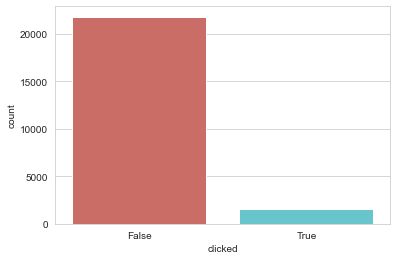

In [244]:
sns.countplot(x='clicked', data=full_data, palette='hls')
plt.show();

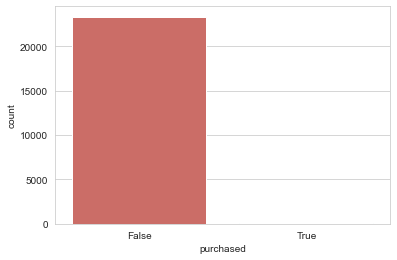

In [295]:
sns.countplot(x='purchased',data=full_data, palette='hls')
plt.show();

### See distribution of good and bad advertisements

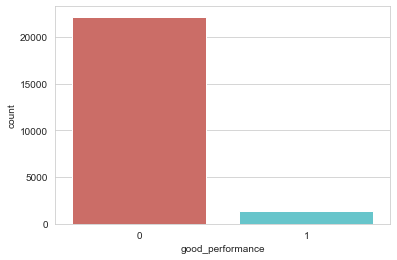

In [296]:
sns.countplot(x='good_performance',data=full_data, palette='hls')
plt.show();

#### Class Distribution

In [317]:
def get_dataset_info(dataframe:pd.core.frame.DataFrame,
                    training_set_column_indicator:str='first_24_hour',
                    test_set_column_indicator:str='test_set',
                    target_column:str= 'next_hour_good_performance')->None:

    training_set = dataframe[dataframe[training_set_column_indicator]]

    print('Training data %: ', (100*training_set.shape[0])/dataframe.shape[0])
    
    good_ads = training_set[training_set[target_column]>0].shape[0]

    print('Training data ads performing good: ', good_ads)
    print('{}% w.r.t training'.format((100*good_ads)/training_data.shape[0]))

    del training_set

    test_set = full_data[full_data[test_set_column_indicator]]

    print('\nTest data total ads: ', test_set.shape[0])
    print('Number of ads with good performance: {}'.format(test_set[test_set[target_column]>0].shape[0]))
    print('{}%'.format((100*test_set[test_set.next_hour_good_performance>0].shape[0])/test_set.shape[0]))
    
    del test_set

In [298]:
get_dataset_info(full_data)

Training data %:  88.90781349797743
Training data ads performing good:  1179
5.646551724137931% w.r.t training

Test data total ads:  2605
Number of ads with good performance: 135
5.182341650671785%


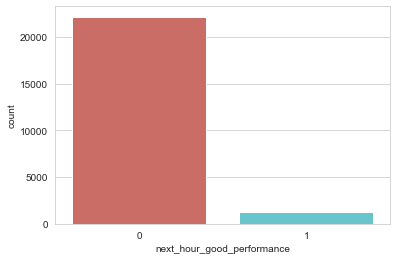

In [299]:
sns.countplot(x='next_hour_good_performance', data=full_data, palette='hls')
plt.show()

### Hourly Pattern

Text(0.5, 1.0, 'Hourly Click Through Rate')

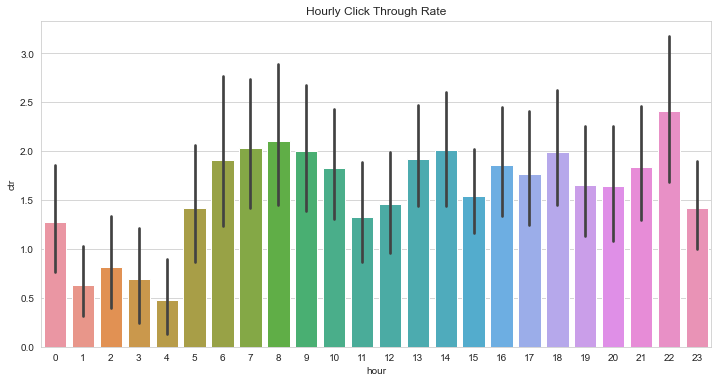

In [270]:
plt.figure(figsize=(12,6))
sns.barplot(y='ctr', x='hour', data=full_data)
plt.title('Hourly Click Through Rate')

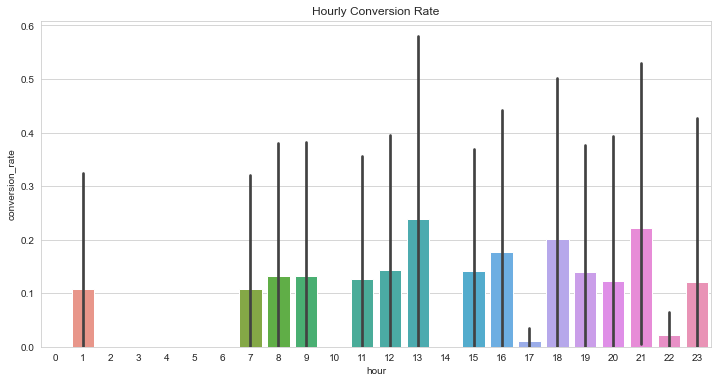

In [271]:
plt.figure(figsize=(12,6))
sns.barplot(y='conversion_rate', x='hour', data=full_data)
plt.title('Hourly Conversion Rate');

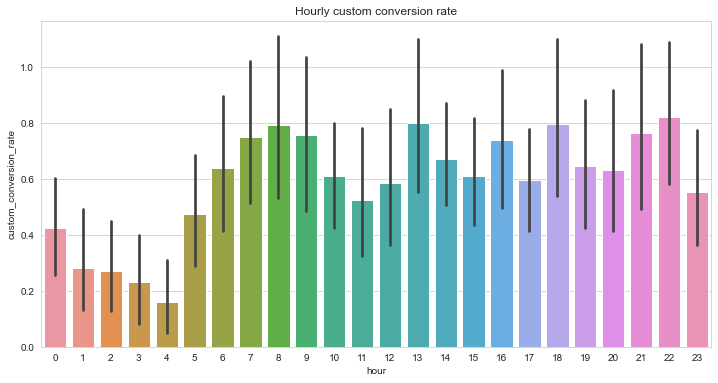

In [135]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='hour', data=full_data)
plt.title('Hourly custom conversion rate');

### Day Of Week

In [136]:
# plt.figure(figsize=(12,6))
# sns.barplot(y='ctr', x='dayofweek', data=full_data)
# plt.title('Day of week Click Through Rate');

In [137]:
# plt.figure(figsize=(12,6))
# sns.barplot(y='conversion_rate', x='dayofweek', data=full_data)
# plt.title('Day of week Conversion Rate');

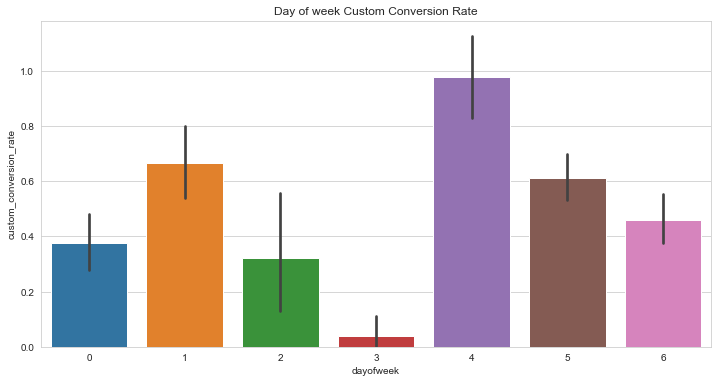

In [138]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='dayofweek', data=full_data)
plt.title('Day of week Custom Conversion Rate');

#### Impact of campaign

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='campaign_id', ylabel='Density'>

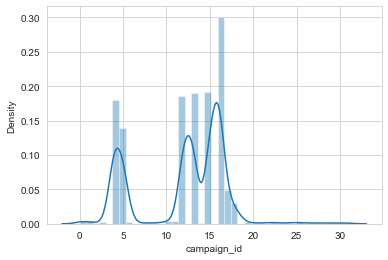

In [139]:
#Campaign Id Histogram
sns.distplot(full_data['campaign_id'])

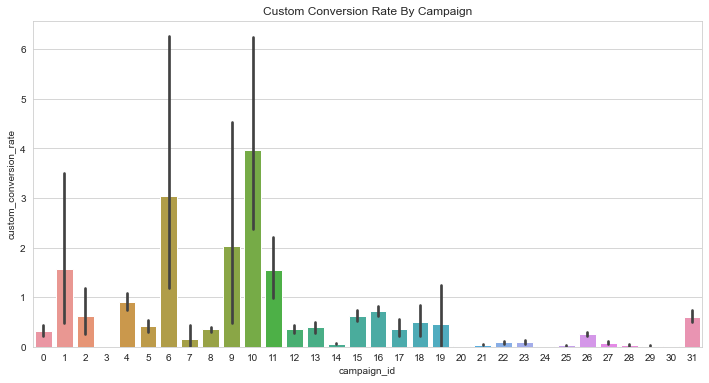

In [140]:
plt.figure(figsize=(12,6))
ax = sns.barplot(y='custom_conversion_rate', x='campaign_id', data=full_data)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Custom Conversion Rate By Campaign');

<AxesSubplot:xlabel='spend', ylabel='custom_conversion_rate'>

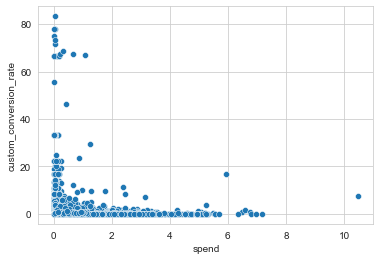

In [141]:
sns.scatterplot(data=full_data, x="spend", y="custom_conversion_rate")

## Relationships

In [300]:
exclude_features = ['datetime', 'unique_ids', 'first_24_hour', 'test_set', 'clicked', 'purchased']

valid_columns = list(set(full_data.columns)-set(exclude_features))
valid_columns

['clicks',
 'hour',
 'dayofweek',
 'impressions',
 'good_performance',
 'ctr',
 'custom_conversion_rate',
 'campaign_id',
 'purchase',
 'spend',
 'conversion_rate',
 'next_hour_good_performance']

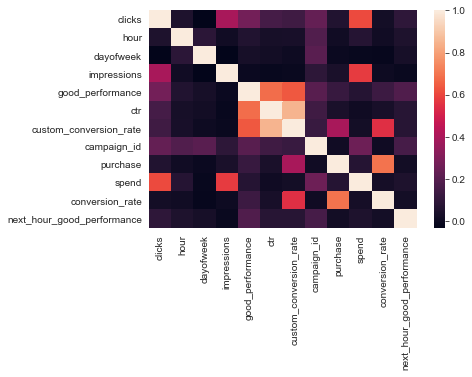

In [279]:
sns.heatmap(full_data[valid_columns].corr());

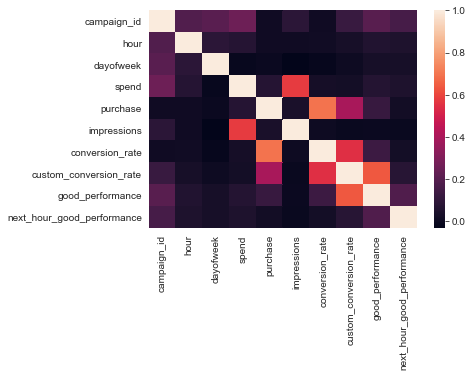

In [314]:
sample_features = ['campaign_id', 'hour', 'dayofweek','spend', 'purchase', 
                   'impressions', 'conversion_rate', 
                   'custom_conversion_rate','good_performance',
                   'next_hour_good_performance']

sns.heatmap(full_data[sample_features].corr());

#full_data[sample_features].corr(method ='pearson')

In [281]:
full_data[sample_features].corr(method ='pearson')

,campaign_id,hour,dayofweek,spend,purchase,impressions,conversion_rate,custom_conversion_rate,good_performance,next_hour_good_performance
campaign_id,1.000000,0.186244,0.207107,0.257827,0.012108,0.089160,0.011780,0.122798,0.202583,0.159310
hour,0.186244,1.000000,0.087089,0.070300,0.012164,0.012294,0.013515,0.032748,0.060120,0.051734
dayofweek,0.207107,0.087089,1.000000,-0.011243,-0.003124,-0.031719,-0.012778,0.006692,0.029684,0.030914
spend,0.257827,0.070300,-0.011243,1.000000,0.070828,0.579817,0.027619,0.023473,0.068829,0.049894
purchase,0.012108,0.012164,-0.003124,0.070828,1.000000,0.037447,0.696970,0.395684,0.119414,0.018954
impressions,0.089160,0.012294,-0.031719,0.579817,0.037447,1.000000,0.006060,-0.004752,-0.002488,-0.006126
conversion_rate,0.011780,0.013515,-0.012778,0.027619,0.696970,0.006060,1.000000,0.550752,0.129785,0.023127
custom_conversion_rate,0.122798,0.032748,0.006692,0.023473,0.395684,-0.004752,0.550752,1.000000,0.637517,0.074289
good_performance,0.202583,0.060120,0.029684,0.068829,0.119414,-0.002488,0.129785,0.637517,1.000000,0.183480
next_hour_good_performance,0.159310,0.051734,0.030914,0.049894,0.018954,-0.006126,0.023127,0.074289,0.183480,1.000000


## Check the distribution


In [161]:
full_data["next_hour_good_performance"] = full_data["next_hour_good_performance"].astype(int)
full_data["good_performance"] = full_data["good_performance"].astype(int)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23485 entries, 0 to 113388
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   datetime                          23485 non-null  datetime64[ns]
 1   campaign_id                       23485 non-null  int64         
 2   time                              23485 non-null  object        
 3   spend                             23485 non-null  float64       
 4   impressions                       23485 non-null  float64       
 5   clicks                            23485 non-null  float64       
 6   purchase                          23485 non-null  float64       
 7   hour                              23485 non-null  int64         
 8   unique_ids                        23485 non-null  object        
 9   first_24_hour                     23485 non-null  bool          
 10  test_set                          23485 non-n

##### Now to check the linearity of the variables it is a good practice to plot distribution graph and look for skewness of features. Kernel density estimate (kde) is a quite useful tool for plotting the shape of a distribution.
Observation:
For all the features, both good and bad performed ads have almost similar distributions


In [283]:
def plot_feature_distributions(feature_list:list, 
                               dataframe:pd.core.frame.DataFrame,
                               target_column:str='next_hour_good_performance'):
    
    for feature in feature_list:
        ax = plt.subplot()
        sns.distplot(dataframe[dataframe[target_column] == 1][feature], bins=50, label='good')
        sns.distplot(dataframe[dataframe[target_column] == 0][feature], bins=50, label='bad')
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(feature))
        plt.legend(loc='best')
        plt.show()

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


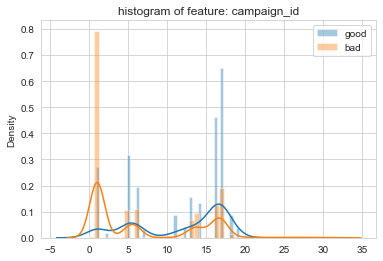

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


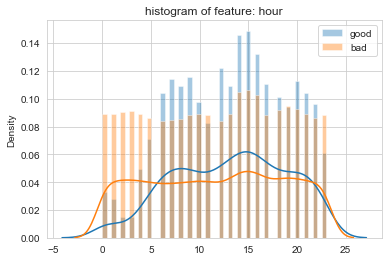

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


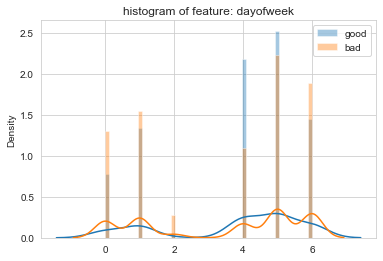

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


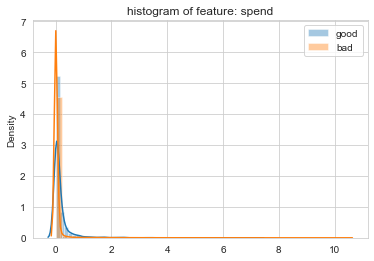

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


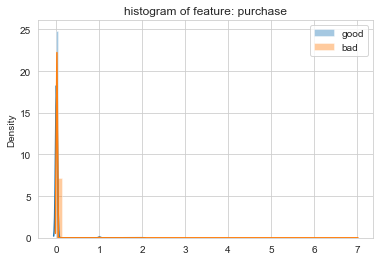

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


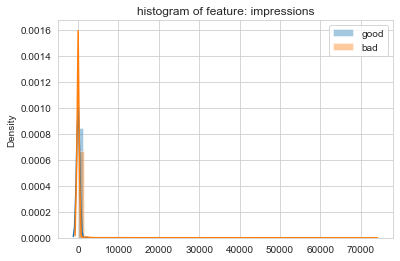

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


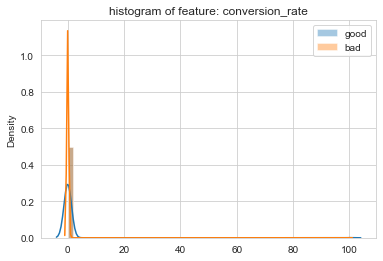

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


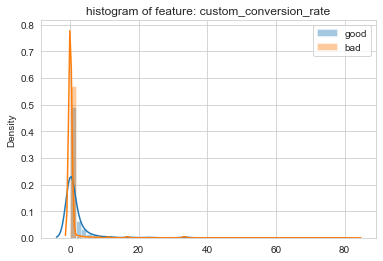

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


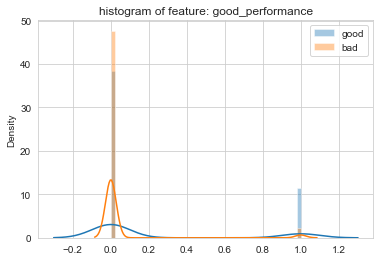

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density 

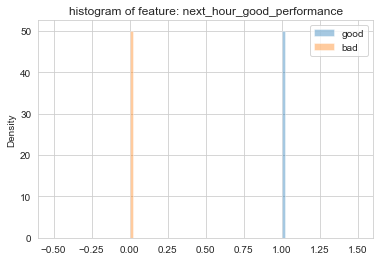

In [284]:
plot_feature_distributions(sample_features, full_data)

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


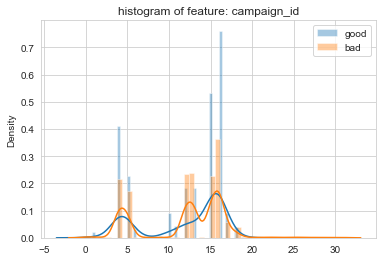

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


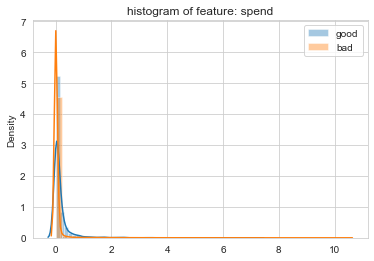

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


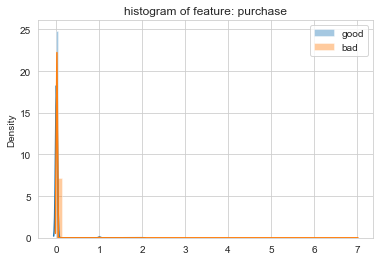

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


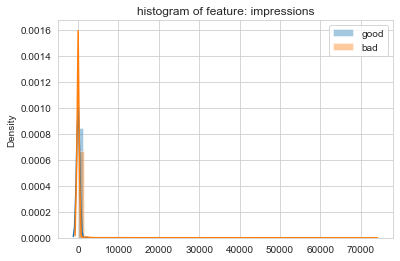

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


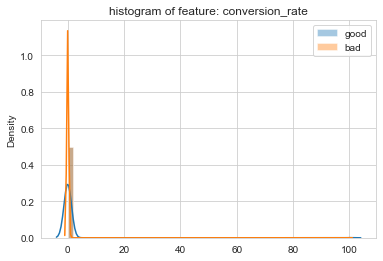

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


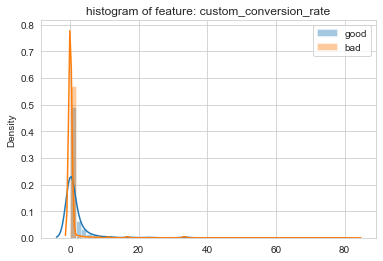

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


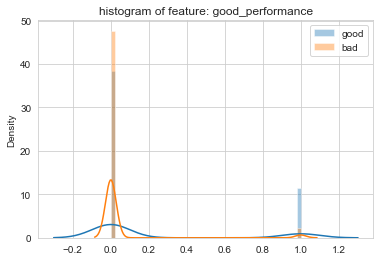

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density 

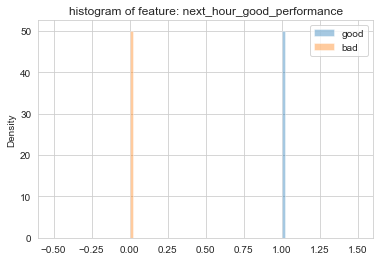

In [197]:
for feature in sample_features:
#     if feature=='hour' or feature=='dayofweek':
#         continue
    ax = plt.subplot()
    sns.distplot(full_data[full_data['next_hour_good_performance'] == 1][feature], bins=50, label='good')
    sns.distplot(full_data[full_data['next_hour_good_performance'] == 0][feature], bins=50, label='bad')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

## Check Outliers and missing values

In [285]:
full_data[sample_features].isna().sum()

campaign_id                   0
hour                          0
dayofweek                     0
spend                         0
purchase                      0
impressions                   0
conversion_rate               0
custom_conversion_rate        0
good_performance              0
next_hour_good_performance    0
dtype: int64

In [146]:
for i in sample_features:
    print(full_data[i].value_counts().head())

0.00    14846
0.01     2312
0.02     1207
0.03      746
0.04      618
Name: spend, dtype: int64
0.0    23451
1.0       30
2.0        2
7.0        1
3.0        1
Name: purchase, dtype: int64
0.0    11397
1.0     3769
2.0     1823
3.0     1122
4.0      776
Name: impressions, dtype: int64
0.000000      23451
100.000000       18
14.285714         3
9.090909          3
33.333333         2
Name: conversion_rate, dtype: int64
0.000000     21303
33.333333      129
16.666667      117
11.111111       87
8.333333        83
Name: custom_conversion_rate, dtype: int64


## Save selected feature info for Modeling

In [239]:
def save_list_as_text_file(path:str, features:list, extension:str='pickle')->None:
    
    try:
        if extension=='pickle':
            with open(path, "wb") as opened_file:   #Pickling
                pickle.dump(features, opened_file)
            print('List saved in: ', path)
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))

In [287]:
save_list_as_text_file("data/feature_lists_for_modeling.txt", sample_features)

List saved in:  data/feature_lists_for_modeling.txt
